# Simulation Dynamics emulator 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
num_experiments = 100
parameter_list = ['gamma', 'gradnoise']

In [5]:
file_names = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [6]:
X = get_parameter_array(file_names,parameter_list)

In [7]:
Y = get_rewards(data_files, average_function_over_time(average_angle_diff_to_peak))
print(np.min(Y))
print(np.max(Y))
print(np.argmin(Y))
print(np.argmax(Y))
print(X[np.argmin(Y)])


1.3679306563256162
1.5749522891104155
62
5
[9.     0.9863]


In [8]:
print(X[np.argmax(Y)])

[21.      0.3425]


In [9]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction



In [10]:
kernel = GPy.kern.RBF(input_dim=2, ARD=True, lengthscale=[1,1], variance=1)
model_gpy = GPRegression(X, Y ,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [11]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


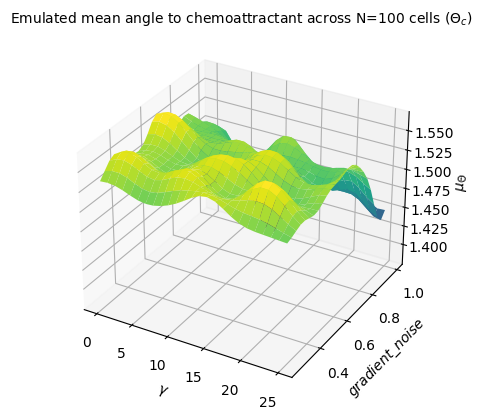

In [12]:
parameter_space = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])

_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Emulated mean angle to chemoattractant across N=100 cells ($\Theta_{c}$)', fontsize=10)
# ax.scatter(model_emukit.X[0][0], model_emukit.X[0][1], model_emukit.Y[0], color='red', s=300, marker='x')
ax.set_xlabel(r'$\gamma$', fontsize=10)
ax.set_ylabel('$gradient\_noise$', fontsize=10)
ax.set_zlabel(r'$\mu_\Theta$', fontsize=10, rotation = 0)
plt.show()

In [13]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
center_of_mass_sa_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = parameter_space)

main_effects_gp, total_effects_gp, _ = center_of_mass_sa_gpbased.compute_effects(num_monte_carlo_points = 10000)

print(main_effects_gp)
print(total_effects_gp)

{'gamma': array([0.23640761]), 'gradnoise': array([1.23272819])}
{'gamma': array([-0.05802401]), 'gradnoise': array([0.46224952])}


(1.2327281891683408, 0.46224951712941476)


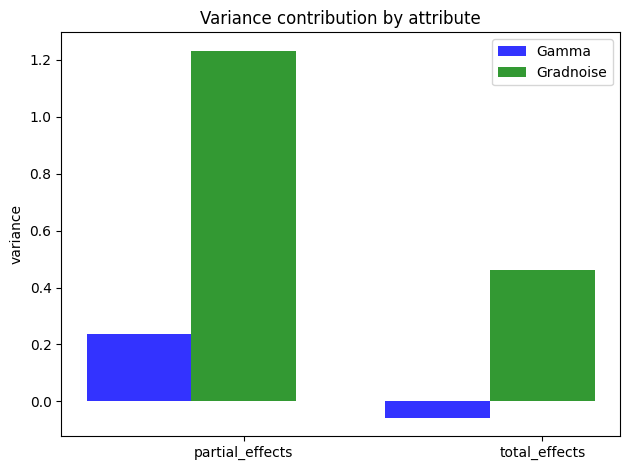

In [14]:
n_groups = 2
means_gamma = (main_effects_gp['gamma'][0], total_effects_gp['gamma'][0] )
means_gradnoise = (main_effects_gp['gradnoise'][0], total_effects_gp['gradnoise'][0])

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_gamma, bar_width,
alpha=opacity,
color='b',
label='Gamma')

rects2 = plt.bar(index + bar_width, means_gradnoise, bar_width,
alpha=opacity,
color='g',
label='Gradnoise')

# plt.xlabel('Variance groups')
plt.ylabel('variance')
plt.title('Variance contribution by attribute')
plt.xticks(index + bar_width, ('partial_effects', 'total_effects'))
plt.legend()

plt.tight_layout()
plt.show()

* As expected, higher gradnoise (counter-intuitive, but it actually leads to higher chemotaxis precision in the C code) leads to better precision. Gamma looks strange (Ideally, the highest precision should be achieved under lowest gamma/ highest gradnoise combination)

In [15]:
Y = get_rewards(data_files, average_function_over_time(average_angle_migration_to_peak))
print(Y[34])


[1.1915152]


In [16]:
print(Y[34])

[1.1915152]


In [17]:
kernel = GPy.kern.RBF(input_dim=2, ARD=True, lengthscale=[1,1], variance=1)
model_gpy = GPRegression(X, Y ,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

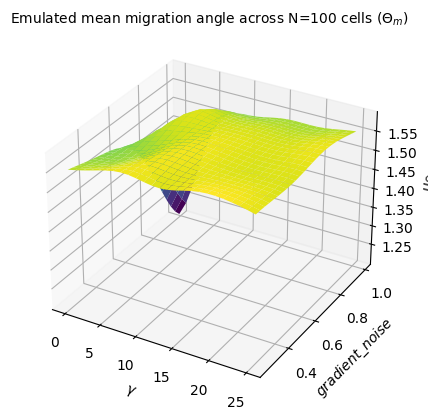

In [18]:
parameter_space = ParameterSpace([
                                DiscreteParameter('gamma',list(range(0,25))),
                                ContinuousParameter('gradnoise',0.25,0.99)])

_gamma_test = np.linspace(0, 25, 25)
_gradnoise_test = np.linspace(0.25, 0.99, 25)

coords_gamma, coords_gradnoise = np.meshgrid(_gamma_test, _gradnoise_test)

_mean, _var = model_emukit.predict(np.c_[coords_gamma.ravel(), coords_gradnoise.ravel()])

reshaped_mean = _mean.reshape(coords_gamma.shape)


ax = plt.axes(projection='3d')
ax.plot_surface(coords_gamma, coords_gradnoise, reshaped_mean, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Emulated mean migration angle across N=100 cells ($\Theta_{m}$)', fontsize=10)
ax.set_xlabel(r'$\gamma$', fontsize=10)
ax.set_ylabel('$gradient\_noise$', fontsize=10)
ax.set_zlabel(r'$\mu_\Theta$', fontsize=10, rotation = 0)
plt.show()